# Statistical Analysis

#### Dependencies

In [1]:
library (ggplot2)
library(tidyr)
library(stringr)
library(vegan)
library(plotly)
library(ggfortify)
library(compositions)
library(ggrepel)
library(tidyverse)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-8


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout


Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: 'compositions'


The following objects are masked from 'package:stats':

    anova, cor, cov, dist, var


The following object is masked from 'package:graphics':

    segments


The following objects are masked from 'package:base':

    %*%, norm, scale, scale.default


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v purrr     1.0.2
v forcats   1.0.0     v readr     2.1.5
v lubridate 1.9.4     v tibble    3.2.1
-- Conflicts ------------------------------------------ tidyverse_confl

## Kraken

Reading File for Metadata

Metadata contains information on the samples and hospital names. The hospitals are labelled as A, B and C respectively. This is provided in the data folder.

In [2]:
metadata <- read.table("/home/jovyan/data/metadata.txt", sep = "\t", header = TRUE)

In [3]:
head(metadata)

,SampleID,alias,date,continent,country,country2,country3,name,hospital,replicate,...,hospital_section,hospital_description,no_of_beds,lat,long,sample_material,DNA_ng_.l,A260_280,M_Seqs_trimmed,plot_name
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,BH02_S77,BH02,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,pediatry,Secondary hospital,200,6.49245,2.40193,water,44.115,1.863,30.8,hospital effluent
2,BH03_S78,BH03,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,surgery,Secondary hospital,200,6.49245,2.40193,water,98.572,1.844,31.6,hospital effluent
3,BFH10_S128,BFH10,28_11_19,West Africa,Burkina Faso,Burkina Faso,BF HWW F,BF HWW F,B,NO,...,other,Health clinic,91,12.50000,-1.66667,water,119.477,1.869,32.0,hospital effluent
4,BFH33_S151,BFH33,12_12_19,West Africa,Burkina Faso,Burkina Faso,BF HWW I,BF HWW I,B,NO,...,other,"Tertiary hospital, a national refrence hospital",733,12.50000,-1.66667,water,72.642,1.857,33.7,hospital effluent
5,FH1_S162,FH1,20_01_20,Europe,Finland,Finland,FI HWW J,FI HWW J,C,NO,...,other,nd,nd,60.19845,24.92737,water,49.300,1.870,21.2,hospital effluent
6,FH2_S163,FH2,20_01_20,Europe,Finland,Finland,FI HWW K,FI HWW K,C,NO,...,other,nd,nd,60.19845,24.92737,water,70.400,1.880,37.9,hospital effluent


Reading File for Kraken Data

Metaphlan data contains results from the taxonomic run earlier, retrieving this from the results folder.

In [4]:
kraken_data <- read.delim("/home/jovyan/results/merged_metakraken_abundance_table.txt", header = TRUE)

#### Merging Kraken Results with Metadata

1. Converts a dataset (`kraken_data`) from **wide** format to **long** format using `pivot_longer`.

From Wide Format (Original Metaphlan Results):
| ID   | Sample1 | Sample2 | Sample3 |
|------|---------|---------|---------|
| Taxa1 | 0.5     | 0.3     | 0.2     |
| Taxa2 | 0.2     | 0.1     | 0.4     |
| Taxa3 | 0.3     | 0.6     | 0.4     |


To Long Format 
| ID   | SampleID | RelativeAbundance |
|------|----------|-------------------|
| Taxa1 | Sample1  | 0.5               |
| Taxa1 | Sample2  | 0.3               |
| Taxa1 | Sample3  | 0.2               |
| Taxa2 | Sample1  | 0.2               |
| Taxa2 | Sample2  | 0.1               |
| Taxa2 | Sample3  | 0.4               |
| Taxa3 | Sample1  | 0.3               |
| Taxa3 | Sample2  | 0.6               |
| Taxa3 | Sample3  | 0.4               |

2. Merges the reshaped data with another dataset (`metadata`) based on a common key, `SampleID`.

In [5]:
kraken_with_metadata <- kraken_data %>%
  pivot_longer(cols = -ID, names_to = "SampleID", values_to = "RelativeAbundance") %>%
  merge(metadata, by = "SampleID", all.x = TRUE)

#### Adding Taxonomic Information
The taxonomic ID in the dataset typically includes hierarchical information in a format like:

`k__Bacteria|p__Firmicutes|c__Clostridia`

This is a hierarchical string, where each part represents a taxonomic rank (e.g., Kingdom, Phylum, Class, etc.). 

For example:

- `k__Bacteria`: Represents Kingdom
- `p__Firmicutes`: Represents Phylum
- `c__Clostridia`: Represents Class


However, in many cases, only the most specific taxonomic rank (like Genus or Species) is of interest. To focus on this specific label, we need to extract the last part of the string (the most specific taxonomic level).

For example:

- Original: `k__Bacteria|p__Firmicutes|c__Clostridia`
- Extracted: Clostridia

This allows you to work with more meaningful and interpretable taxonomic labels (e.g., species names) rather than the entire hierarchical string.

In [6]:
# Add taxonomic information (level and label)
kraken_with_metadata$Taxonomic_Level <- sapply(strsplit(as.character(kraken_with_metadata$ID), "\\|"), length)
kraken_with_metadata$Taxonomic_Label <- sapply(kraken_with_metadata$ID, function(x) {
  labels <- c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")
  level <- length(strsplit(x, "\\|")[[1]])
  if (level <= 7) labels[level] else "Other"
})

# Extract descriptive ID and remove "Other" labels
kraken_with_metadata$ID <- sapply(kraken_with_metadata$ID, function(x) sub(".*__", "", tail(strsplit(x, "\\|")[[1]], 1)))
kraken_with_metadata <- kraken_with_metadata[kraken_with_metadata$Taxonomic_Label != "Other", ]

# Split data by taxonomic label and reshape into wide format
wide_data <- kraken_with_metadata %>%
  split(.$Taxonomic_Label) %>%
  purrr::map(~ pivot_wider(.x, names_from = ID, values_from = RelativeAbundance))
  

wide_genus_data <- wide_data$Genus
wide_species_data <- wide_data$Species
wide_phylum_data <- wide_data$Phylum

# View the reshaped wide data
head(wide_data)


SampleID,alias,date,continent,country,country2,country3,name,hospital,replicate,...,BeAn_58058_virus,Tectivirus,Pandoravirus_dulcis,Pandoravirus_inopinatum,Pandoravirus_salinus,Tospoviridae,Ackermannviridae,Myoviridae,Epsilonproteobacteria,Gammaproteobacteria
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BFH10_S128,BFH10,28_11_19,West Africa,Burkina Faso,Burkina Faso,BF HWW F,BF HWW F,B,NO,...,0.00000e+00,0.00000e+00,0.000117059,3.51177e-04,0.000351177,0.00000e+00,0.000000000,0.00608706,2.125440,5.82602
BFH33_S151,BFH33,12_12_19,West Africa,Burkina Faso,Burkina Faso,BF HWW I,BF HWW I,B,NO,...,0.00000e+00,6.64309e-05,0.000000000,0.00000e+00,0.000000000,3.32155e-04,0.000000000,0.23955000,6.686070,41.71240
BH02_S77,BH02,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,0.00000e+00,0.00000e+00,0.000000000,9.24408e-05,0.000000000,0.00000e+00,0.000739527,0.01063070,0.210210,58.55210
BH03_S78,BH03,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,0.00000e+00,4.19822e-04,0.000000000,0.00000e+00,0.000104955,0.00000e+00,0.005877510,0.02907270,0.220302,5.78578
FH1_S162,FH1,20_01_20,Europe,Finland,Finland,FI HWW J,FI HWW J,C,NO,...,0.00000e+00,0.00000e+00,0.000000000,0.00000e+00,0.000000000,7.11076e-05,0.000000000,0.16575200,2.765230,52.31220
FH2_S163,FH2,20_01_20,Europe,Finland,Finland,FI HWW K,FI HWW K,C,NO,...,8.05431e-05,8.05431e-05,0.000000000,0.00000e+00,0.000000000,4.02716e-04,0.000241629,0.00757105,5.820050,26.62020
SampleID,alias,date,continent,country,country2,country3,name,hospital,replicate,...,Plesiomonas,Candidatus_Thioglobus_autotrophicus,Candidatus_Ruthia_magnifica,Immundisolibacteraceae,Gallaecimonas_sp._HK-28,Candidatus_Thioglobus_singularis,Thiolapillus_brandeum,Sedimenticola_thiotaurini,Pseudohongiella_spirulinae,Thiohalobacter_thiocyanaticus
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BFH10_S128,BFH10,28_11_19,West Africa,Burkina Faso,Burkina Faso,BF HWW F,BF HWW F,B,NO,...,0.000468235,5.85294e-04,0.000819412,0.01322770,0.001990000,1.28765e-03,0.004448240,0.00304353,0.000234118,0.00913059


#### Principal Component Analysis (PCA) on Genus Data
In this section, we will perform Principal Component Analysis (PCA) on the wide genus data and visualize the results. PCA is a technique used to reduce the dimensionality of data while retaining as much variability as possible. This will allow us to identify patterns in the data based on the first two principal components.

`select(c(18: ncol(wide_genus_data)))`: This selects columns starting from the 18th column to the last column in the wide_genus_data dataset. These columns represent the numerical data (i.e., the relative abundances of different genera).

In [8]:
numerical <- wide_genus_data%>% select(c(18: ncol(wide_genus_data)))

The `clr()` function is applied to the numerical data. CLR transformation converts the relative abundances into log-transformed values, accounting for compositional data and improving the performance of PCA.

In [9]:
numerical <- clr(numerical)

We perform PCA using the `rda()` function from the vegan package. The result will be a set of principal components that explain the variance in the genus data.

In [10]:
pca_result <- rda(numerical)

Once the PCA has been computed, we extract the PCA scores for the samples (also known as sites). These scores represent the projections of each sample along the principal components.

In [11]:
# Extract PCA scores for the samples (sites)
pca_scores <- scores(pca_result, display = "sites")
pca_data <- as.data.frame(pca_scores)

##### Add Metadata to PCA Data
We now add additional metadata, such as the hospital and SampleID, to the PCA scores data frame. This will allow us to visualize how these variables relate to the PCA results.

In [12]:
pca_data$hospital <- wide_genus_data$hospital
pca_data$SampleID <- wide_genus_data$SampleID

##### Visualize PCA Results

Finally, we visualize the PCA results using ggplot2. We plot the first two principal components (PC1 and PC2) and color the points by the hospital variable. We also add labels for each sample using SampleID.

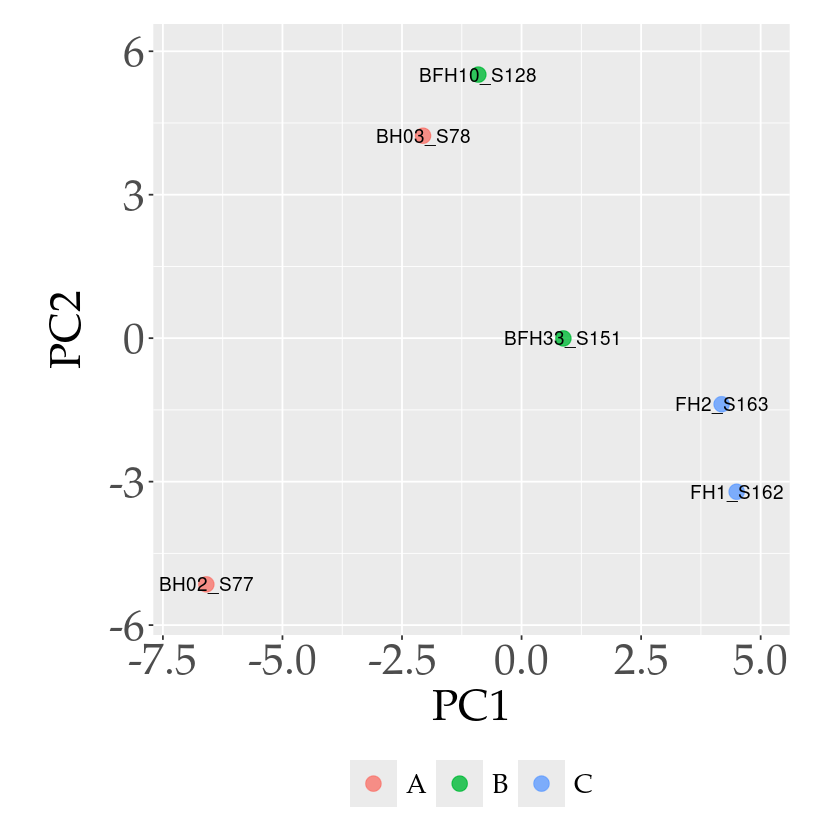

In [13]:
p <- ggplot(pca_data, aes(x = PC1, y = PC2, label = SampleID, group = hospital)) +
  geom_point(aes(color = hospital), size = 4, alpha = 0.8) + 
  geom_text(size = 4) +  
  coord_fixed(ratio = 1) +  # Ensures equal scaling for x and y axes
  theme(text = element_text(family = "Palatino"),
        legend.title = element_blank(),
        legend.text = element_text(size = 16),
        legend.key.size = unit(1, 'cm'),
        legend.position = "bottom",
        legend.background = element_rect(color = "#ffffff"),
        legend.direction = "horizontal",
        axis.text.x = element_text(size = 26, angle = 0, hjust = 0.5),
        axis.text.y = element_text(size = 26),
        axis.title.x = element_text(size = 26),                       
        axis.title.y = element_text(size = 26),  
        plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm")) +
  scale_x_continuous(expand = expansion(mult = c(0.1, 0.1))) +  # Adds 10% padding
  scale_y_continuous(expand = expansion(mult = c(0.1, 0.1)))    # Adds 10% padding

print(p)

## Metaphlan

Reading File for Metadata

Metadata contains information on the samples and hospital names. The hospitals are labelled as A, B and C respectively. This is provided in the data folder.

In [ ]:
metadata <- read.table("/home/jovyan/data/metadata.txt", sep = "\t", header = TRUE)

In [ ]:
head(metadata)

,SampleID,alias,date,continent,country,country2,country3,name,hospital,replicate,...,hospital_section,hospital_description,no_of_beds,lat,long,sample_material,DNA_ng_.l,A260_280,M_Seqs_trimmed,plot_name
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,BH02_S77,BH02,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,pediatry,Secondary hospital,200,6.49245,2.40193,water,44.115,1.863,30.8,hospital effluent
2,BH03_S78,BH03,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,surgery,Secondary hospital,200,6.49245,2.40193,water,98.572,1.844,31.6,hospital effluent
3,BFH10_S128,BFH10,28_11_19,West Africa,Burkina Faso,Burkina Faso,BF HWW F,BF HWW F,B,NO,...,other,Health clinic,91,12.50000,-1.66667,water,119.477,1.869,32.0,hospital effluent
4,BFH33_S151,BFH33,12_12_19,West Africa,Burkina Faso,Burkina Faso,BF HWW I,BF HWW I,B,NO,...,other,"Tertiary hospital, a national refrence hospital",733,12.50000,-1.66667,water,72.642,1.857,33.7,hospital effluent
5,FH1_S162,FH1,20_01_20,Europe,Finland,Finland,FI HWW J,FI HWW J,C,NO,...,other,nd,nd,60.19845,24.92737,water,49.300,1.870,21.2,hospital effluent
6,FH2_S163,FH2,20_01_20,Europe,Finland,Finland,FI HWW K,FI HWW K,C,NO,...,other,nd,nd,60.19845,24.92737,water,70.400,1.880,37.9,hospital effluent


Reading File for Metaphlan Data

Metaphlan data contains results from the taxonomic run earlier, retrieving this from the results folder.

In [ ]:
# Skip first column as it contains the mpa version
metaphlan_data <- read.delim("merged_abundance_table.txt", header = TRUE, skip =1)
# To make it simpler, we rename clade_name to ID (as clade_name refers to the taxonomic ID)
colnames(metaphlan_data)[colnames(metaphlan_data) == "clade_name"] <- "ID"

#### Merging Metaphlan Results with Metadata

1. Converts a dataset (`metaphlan_data`) from **wide** format to **long** format using `pivot_longer`.

From Wide Format (Original Metaphlan Results):
| ID   | Sample1 | Sample2 | Sample3 |
|------|---------|---------|---------|
| Taxa1 | 0.5     | 0.3     | 0.2     |
| Taxa2 | 0.2     | 0.1     | 0.4     |
| Taxa3 | 0.3     | 0.6     | 0.4     |


To Long Format 
| ID   | SampleID | RelativeAbundance |
|------|----------|-------------------|
| Taxa1 | Sample1  | 0.5               |
| Taxa1 | Sample2  | 0.3               |
| Taxa1 | Sample3  | 0.2               |
| Taxa2 | Sample1  | 0.2               |
| Taxa2 | Sample2  | 0.1               |
| Taxa2 | Sample3  | 0.4               |
| Taxa3 | Sample1  | 0.3               |
| Taxa3 | Sample2  | 0.6               |
| Taxa3 | Sample3  | 0.4               |

2. Merges the reshaped data with another dataset (`metadata`) based on a common key, `SampleID`.

In [ ]:
metaphlan_with_metadata <- metaphlan_data %>%
  pivot_longer(cols = -ID, names_to = "SampleID", values_to = "RelativeAbundance") %>%
  merge(metadata, by = "SampleID", all.x = TRUE)

#### Adding Taxonomic Information
The taxonomic ID in the dataset typically includes hierarchical information in a format like:

`k__Bacteria|p__Firmicutes|c__Clostridia`

This is a hierarchical string, where each part represents a taxonomic rank (e.g., Kingdom, Phylum, Class, etc.). 

For example:

- `k__Bacteria`: Represents Kingdom
- `p__Firmicutes`: Represents Phylum
- `c__Clostridia`: Represents Class


However, in many cases, only the most specific taxonomic rank (like Genus or Species) is of interest. To focus on this specific label, we need to extract the last part of the string (the most specific taxonomic level).

For example:

- Original: `k__Bacteria|p__Firmicutes|c__Clostridia`
- Extracted: Clostridia

This allows you to work with more meaningful and interpretable taxonomic labels (e.g., species names) rather than the entire hierarchical string.

In [ ]:
# Add taxonomic information (level and label)
metaphlan_with_metadata$Taxonomic_Level <- sapply(strsplit(as.character(metaphlan_with_metadata$ID), "\\|"), length)
metaphlan_with_metadata$Taxonomic_Label <- sapply(metaphlan_with_metadata$ID, function(x) {
  labels <- c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")
  level <- length(strsplit(x, "\\|")[[1]])
  if (level <= 7) labels[level] else "Other"
})

# Extract descriptive ID and remove "Other" labels
metaphlan_with_metadata$ID <- sapply(metaphlan_with_metadata$ID, function(x) sub(".*__", "", tail(strsplit(x, "\\|")[[1]], 1)))
metaphlan_with_metadata <- metaphlan_with_metadata[metaphlan_with_metadata$Taxonomic_Label != "Other", ]

# Split data by taxonomic label and reshape into wide format
wide_data <- metaphlan_with_metadata %>%
  split(.$Taxonomic_Label) %>%
  purrr::map(~ pivot_wider(.x, names_from = ID, values_from = RelativeAbundance))
  

wide_genus_data <- wide_data$Genus
wide_species_data <- wide_data$Species
wide_phylum_data <- wide_data$Phylum

# View the reshaped wide data
head(wide_data)


SampleID,alias,date,continent,country,country2,country3,name,hospital,replicate,...,BeAn_58058_virus,Tectivirus,Pandoravirus_dulcis,Pandoravirus_inopinatum,Pandoravirus_salinus,Tospoviridae,Ackermannviridae,Myoviridae,Epsilonproteobacteria,Gammaproteobacteria
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BFH10_S128,BFH10,28_11_19,West Africa,Burkina Faso,Burkina Faso,BF HWW F,BF HWW F,B,NO,...,0.00000e+00,0.00000e+00,0.000117059,3.51177e-04,0.000351177,0.00000e+00,0.000000000,0.00608706,2.125440,5.82602
BFH33_S151,BFH33,12_12_19,West Africa,Burkina Faso,Burkina Faso,BF HWW I,BF HWW I,B,NO,...,0.00000e+00,6.64309e-05,0.000000000,0.00000e+00,0.000000000,3.32155e-04,0.000000000,0.23955000,6.686070,41.71240
BH02_S77,BH02,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,0.00000e+00,0.00000e+00,0.000000000,9.24408e-05,0.000000000,0.00000e+00,0.000739527,0.01063070,0.210210,58.55210
BH03_S78,BH03,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,0.00000e+00,4.19822e-04,0.000000000,0.00000e+00,0.000104955,0.00000e+00,0.005877510,0.02907270,0.220302,5.78578
FH1_S162,FH1,20_01_20,Europe,Finland,Finland,FI HWW J,FI HWW J,C,NO,...,0.00000e+00,0.00000e+00,0.000000000,0.00000e+00,0.000000000,7.11076e-05,0.000000000,0.16575200,2.765230,52.31220
FH2_S163,FH2,20_01_20,Europe,Finland,Finland,FI HWW K,FI HWW K,C,NO,...,8.05431e-05,8.05431e-05,0.000000000,0.00000e+00,0.000000000,4.02716e-04,0.000241629,0.00757105,5.820050,26.62020
SampleID,alias,date,continent,country,country2,country3,name,hospital,replicate,...,Plesiomonas,Candidatus_Thioglobus_autotrophicus,Candidatus_Ruthia_magnifica,Immundisolibacteraceae,Gallaecimonas_sp._HK-28,Candidatus_Thioglobus_singularis,Thiolapillus_brandeum,Sedimenticola_thiotaurini,Pseudohongiella_spirulinae,Thiohalobacter_thiocyanaticus
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BFH10_S128,BFH10,28_11_19,West Africa,Burkina Faso,Burkina Faso,BF HWW F,BF HWW F,B,NO,...,0.000468235,5.85294e-04,0.000819412,0.01322770,0.001990000,1.28765e-03,0.004448240,0.00304353,0.000234118,0.00913059


#### Principal Component Analysis (PCA) on Genus Data
In this section, we will perform Principal Component Analysis (PCA) on the wide genus data and visualize the results. PCA is a technique used to reduce the dimensionality of data while retaining as much variability as possible. This will allow us to identify patterns in the data based on the first two principal components.

`select(c(18: ncol(wide_genus_data)))`: This selects columns starting from the 18th column to the last column in the wide_genus_data dataset. These columns represent the numerical data (i.e., the relative abundances of different genera).

In [ ]:
numerical <- wide_genus_data%>% select(c(18: ncol(wide_genus_data)))

The `clr()` function is applied to the numerical data. CLR transformation converts the relative abundances into log-transformed values, accounting for compositional data and improving the performance of PCA.

In [ ]:
numerical <- clr(numerical)

We perform PCA using the `rda()` function from the vegan package. The result will be a set of principal components that explain the variance in the genus data.

In [ ]:
pca_result <- rda(numerical)

Once the PCA has been computed, we extract the PCA scores for the samples (also known as sites). These scores represent the projections of each sample along the principal components.

In [ ]:
# Extract PCA scores for the samples (sites)
pca_scores <- scores(pca_result, display = "sites")
pca_data <- as.data.frame(pca_scores)

##### Add Metadata to PCA Data
We now add additional metadata, such as the hospital and SampleID, to the PCA scores data frame. This will allow us to visualize how these variables relate to the PCA results.

In [ ]:
pca_data$hospital <- wide_genus_data$hospital
pca_data$SampleID <- wide_genus_data$SampleID

##### Visualize PCA Results

Finally, we visualize the PCA results using ggplot2. We plot the first two principal components (PC1 and PC2) and color the points by the hospital variable. We also add labels for each sample using SampleID.

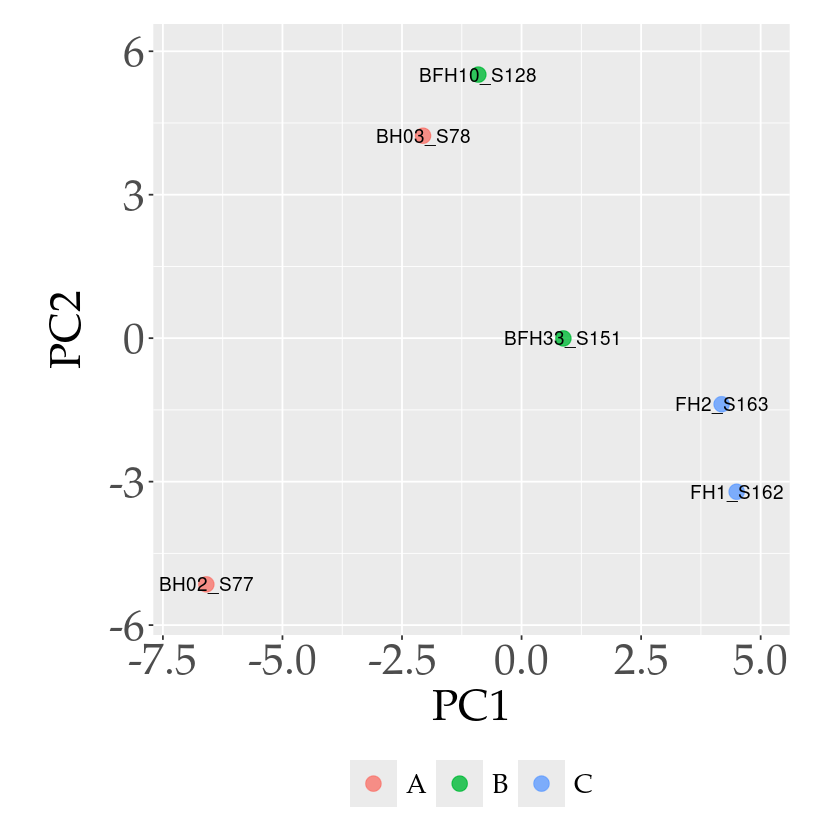

In [ ]:
p <- ggplot(pca_data, aes(x = PC1, y = PC2, label = SampleID, group = hospital)) +
  geom_point(aes(color = hospital), size = 4, alpha = 0.8) + 
  geom_text(size = 4) +  
  coord_fixed(ratio = 1) +  # Ensures equal scaling for x and y axes
  theme(text = element_text(family = "Palatino"),
        legend.title = element_blank(),
        legend.text = element_text(size = 16),
        legend.key.size = unit(1, 'cm'),
        legend.position = "bottom",
        legend.background = element_rect(color = "#ffffff"),
        legend.direction = "horizontal",
        axis.text.x = element_text(size = 26, angle = 0, hjust = 0.5),
        axis.text.y = element_text(size = 26),
        axis.title.x = element_text(size = 26),                       
        axis.title.y = element_text(size = 26),  
        plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm")) +
  scale_x_continuous(expand = expansion(mult = c(0.1, 0.1))) +  # Adds 10% padding
  scale_y_continuous(expand = expansion(mult = c(0.1, 0.1)))    # Adds 10% padding

print(p)

## ARG

#### Importing All Files from ARG Run

Note: The file for the lengths of the Resfinder reference genes is already PROVIDED in the data folder.

In [25]:
# using the same metadata as earlier
metaxa_data <- read.delim("/home/jovyan/results/metaxa_genus.txt", header = TRUE)
arg_data <- read.delim("/home/jovyan/results/ARG_genemat.txt", header = TRUE)
resfinder_lengths<- read.delim("/home/jovyan/data/resfinder_lengths.txt", header = TRUE)

We start by converting the Metaxa data from a wide format to a long format.

In [26]:
# Transform Metaxa data to long format
long_metaxa <- metaxa_data %>%
  pivot_longer(cols = -Taxa, names_to = "SampleID", values_to = "Count")

##### Merge Metaxa Data with Metadata
Once the Metaxa data is in the long format, we can merge it with additional metadata to provide more context for each sample

In [27]:
combined_metaxa <- merge(long_metaxa, metadata, by = "SampleID", all.x = TRUE)

##### Merge ARG Data with Gene Length Information

Next, we transform and merge additional ARG data with gene length information. 

In [28]:
combined_length <- merge (arg_data, resfinder_lengths, by = "GENE", all.x = TRUE)

 Metaxa counts refer to the number of reads associated with various taxa (microbial species or groups) derived from the 16S rRNA gene sequences processed by Metaxa2. 

 By using group_by(SampleID), we are aggregating the counts per sample, so each SampleID will have a total number of 16S rRNA reads across all taxa, which is stored in the new column Metaxa_Counts.

In [29]:
metaxa_counts <- combined_metaxa %>%
  group_by(SampleID) %>%
  summarize(Metaxa_Counts = sum(Count))

Normalization by Metaxa Counts

After obtaining the Metaxa counts for each sample, we can use these counts to normalize other data, like ARG data, to account for the varying microbial abundance across samples. 

Metaxa counts are used to adjust the ARG counts by dividing the ARG values by the Metaxa counts (microbial abundance). For normalization, a factor of 1540 bp was used, representing the average length of the 16S rRNA gene in *Escherichia. coli*.


The first line assigns the GENE column as the row names of the combined_length dataset. This means that the gene names will now be used as identifiers for each row, rather than being stored as a regular column.

The second line removes the GENE column from the data frame since its information is now encoded in the row names.

In [30]:
# Make GENE column into row names
rownames(combined_length) <- combined_length$GENE

# Remove GENE column
combined_length <- combined_length %>% select(-GENE)

Divides the counts for each gene by its respective gene length (found in the length column). This is then sorted alphabentically according to the ARG names.

In [31]:
# Normalize reads by gene lengths
arg_length_norm <- combined_length[, 1:(ncol(combined_length)-1)]  / combined_length$length

# Sort columns alphabetically to match with ssu_counts
arg_length_norm <- arg_length_norm[ , order(names(arg_length_norm))]

1. The first line transposes (`t()`) the arg_length_norm dataset, so that samples are now represented by rows and genes by columns.

2. The sweep() function is used to perform an element-wise operation (in this case, division) across the rows of the transposed arg_length_norm data using the transposed metaxa_counts data. 

3. Finally, the transposed matrix is multiplied by a scaling factor (1540).

In [32]:
# Normalize reads by gene lengths
arg_length_norm <- combined_length[, 1:(ncol(combined_length)-1)]  / combined_length$length

# Sort columns alphabetically to match with ssu_counts
arg_length_norm <- arg_length_norm[ , order(names(arg_length_norm))]

# Normalization with Metaxa2 SSU counts
arg_length_norm_t <- t(arg_length_norm)
metaxa_counts <- metaxa_counts %>% select(-SampleID)
arg_length_norm_t <- sweep(arg_length_norm_t, 1, t(metaxa_counts), FUN = "/")
arg_length_metaxa_norm <- t(arg_length_norm_t) * 1540


# Replace counts in card_data with normalized values
normalized_arg_data <- as.data.frame(arg_length_metaxa_norm) %>%
  mutate(GENE = rownames(arg_length_metaxa_norm)) %>%
  select(GENE, everything())

##### Reshaping data

This is needed for merging the normalized ARG data with metadata.

Before transformation:
| **GENE** | **Sample1** | **Sample2** | **Sample3** |
|----------|-------------|-------------|-------------|
| GENE1    | 0.12        | 0.34        | 0.22        |
| GENE2    | 0.45        | 0.67        | 0.59        |
| GENE3    | 0.78        | 0.56        | 0.49        |

After transformation:
| **GENE** | **SampleID** | **Count** |
|----------|--------------|-----------|
| GENE1    | Sample1      | 0.12      |
| GENE2    | Sample1      | 0.45      |
| GENE3    | Sample1      | 0.78      |
| GENE1    | Sample2      | 0.34      |
| GENE2    | Sample2      | 0.67      |
| GENE3    | Sample2      | 0.56      |
| GENE1    | Sample3      | 0.22      |
| GENE2    | Sample3      | 0.59      |
| GENE3    | Sample3      | 0.49      |

In [35]:
long_arg <- normalized_arg_data %>%
  pivot_longer(cols = -GENE, names_to = "SampleID", values_to = "Count")

#### Merging Normalized data with Metadata

In [39]:
combined_data <- merge(long_arg, metadata, by = "SampleID", all.x = TRUE)


This reshapes the combined_data into a wide format using pivot_wider(). In the resulting dataset:
- Each SampleID will have one row.
- Each GENE will have its own column.
- The Count for each gene in each sample is placed in the corresponding cell.

In [40]:

# Reshape the data so that one row is one sample using pivot_wider
arg_df <- combined_data %>%
  pivot_wider(names_from = GENE, values_from = Count)

head(arg_df)


SampleID,alias,date,continent,country,country2,country3,name,hospital,replicate,...,blaTEM-45_1_X95401,fosA_2_AGDM01000012,fosA7_1_LAPJ01000014,blaTEM-36_1_KY305958,blaTEM-34_1_KC292503,blaTEM-49_1_Y10281,blaTEM-47_1_Y10279,blaTEM-4_1_LK391770,fosA_1_M85195,blaTEM-3_1_X64523
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BFH10_S128,BFH10,28_11_19,West Africa,Burkina Faso,Burkina Faso,BF HWW F,BF HWW F,B,NO,...,NA,NA,NA,0.0000000000,NA,NA,NA,0.0000000000,NA,NA
BFH33_S151,BFH33,12_12_19,West Africa,Burkina Faso,Burkina Faso,BF HWW I,BF HWW I,B,NO,...,NA,NA,NA,0.0000000000,NA,NA,NA,0.0000000000,NA,NA
BH02_S77,BH02,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,NA,NA,NA,0.0005152291,NA,NA,NA,0.0005152291,NA,NA
BH03_S78,BH03,27_11_19,West Africa,Benin,Benin,BENN HWW A,BENN HWW A,A,NO,...,NA,NA,NA,0.0000000000,NA,NA,NA,0.0000000000,NA,NA
FH1_S162,FH1,20_01_20,Europe,Finland,Finland,FI HWW J,FI HWW J,C,NO,...,NA,NA,NA,0.0012951614,NA,NA,NA,0.0000000000,NA,NA
FH2_S163,FH2,20_01_20,Europe,Finland,Finland,FI HWW K,FI HWW K,C,NO,...,NA,NA,NA,0.0000000000,NA,NA,NA,0.0000000000,NA,NA


#### Principal Component Analysis (PCA) on Genus Data
In this section, we will perform Principal Component Analysis (PCA) on the ARG data and visualize the results.

`select(c(18: ncol(wide_genus_data)))`: This selects columns starting from the 16th column to the last column in the wide_genus_data dataset. These columns represent the numerical data.

In [41]:
arg_numerical <- arg_df %>% select(c(16:ncol(arg_df)))

The `clr()` function is applied to the numerical data. CLR transformation converts the counts into log-transformed values, accounting for compositional data and improving the performance of PCA.

In [42]:
arg_numerical <- clr(arg_numerical)


We perform PCA using the `rda()` function from the vegan package.

In [43]:
pca_result <- rda(arg_numerical)

Once the PCA has been computed, we extract the PCA scores for the samples (also known as sites). These scores represent the projections of each sample along the principal components.

In [44]:
pca_scores <- scores(pca_result, display = "sites")
pca_data <- as.data.frame(pca_scores)

##### Add Metadata to PCA Data
We now add additional metadata, such as the hospital and SampleID, to the PCA scores data frame. This will allow us to visualize how these variables relate to the PCA results.

In [45]:
pca_data$hospital <- arg_df$hospital
pca_data$SampleID <- arg_df$SampleID

##### Visualize PCA Results

Finally, we visualize the PCA results using ggplot2. We plot the first two principal components (PC1 and PC2) and color the points by the hospital variable. We also add labels for each sample using SampleID.

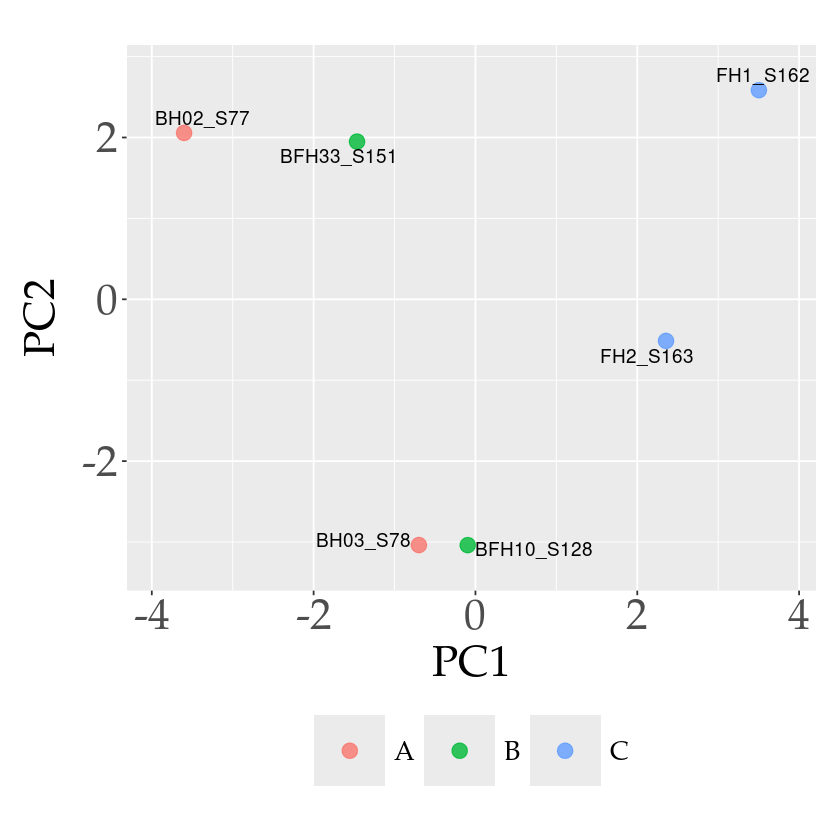

In [46]:
p <- ggplot(pca_data, aes(x = PC1, y = PC2, label = SampleID, group = hospital)) +
  geom_point(aes(color = hospital), size = 4, alpha = 0.8) + 
  geom_text_repel(aes(label = SampleID), size = 4, max.overlaps = Inf) +  # Avoid overlap
  coord_fixed(ratio = 1) +  # Ensures equal scaling for x and y axes
  theme(text = element_text(family = "Palatino"),
        legend.title = element_blank(),
        legend.text = element_text(size = 16),
        legend.key.size = unit(1.5, 'cm'),
        legend.position = "bottom",
        legend.background = element_rect(color = "#ffffff"),
        legend.direction = "horizontal",
        axis.text.x = element_text(size = 26, angle = 0, hjust = 0.5),
        axis.text.y = element_text(size = 26),
        axis.title.x = element_text(size = 26),                       
        axis.title.y = element_text(size = 26),  
        plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm")) +
  scale_x_continuous(expand = expansion(mult = c(0.1, 0.1))) +  # Adds 10% padding
  scale_y_continuous(expand = expansion(mult = c(0.1, 0.1)))    # Adds 10% padding

print(p)